### Imports

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose as season
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import metrics
from sklearn.linear_model import LinearRegression


### Initial Examination of the provided data

In [2]:
# Reading in the provided CSV file

df = pd.read_csv("zillow_data.csv")
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df.shape

(14723, 272)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


### Creating a dataframe with a datetime index

In [5]:
def zipcodecolumns_datetimeindex(df):
    '''
    Very specific function that takes our provided dataframe, df, and changes
    it so that the zipcode, RegionName, is the index and the columns are all
    the timeseries data
    Assumes each zipcode is unique!
    
    Expected inputs:
    df - The provided pandas dataframe with all original columns, where the 
         dates are unfortunately the columns and not easily indexable
         
    Output:
    df_datetime - pandas dataframe where the datetime is now the index, and
                  each column is now the zipcode, RegionName
                  The other metadata columns are dropped
    '''
    # Changes the index to be each zipcode
    df_zipcode = df.set_index(df["RegionName"])
    
    # Drops the metadata columns from the provided df
    df_zipcode = df_zipcode.drop(columns=["RegionID", "RegionName", 
                                          "City", "State", "Metro", 
                                          "CountyName", "SizeRank"])
    # Transposes the df, so now the remaining columns (dates) are the index
    df_datetime = df_zipcode.transpose()
    # Changes those dates to be actual datetime objects instead of strings
    df_datetime.index = pd.to_datetime(df_datetime.index)
    
    return df_datetime

In [6]:
df_t = zipcodecolumns_datetimeindex(df)
df_t.shape

(265, 14723)

### Overall View of the National Average

In [7]:
df_t.head()

RegionName,60657,75070,77494,60614,79936,77084,10467,60640,77449,94109,...,3765,84781,12429,97028,12720,1338,3293,40404,81225,89155
1996-04-01,334200.0,235700.0,210400.0,498100.0,77300.0,95000.0,152900.0,216500.0,95400.0,766000.0,...,80800.0,135900.0,78300.0,136200.0,62500.0,94600.0,92700.0,57100.0,191100.0,176400.0
1996-05-01,335400.0,236900.0,212200.0,500900.0,77300.0,95200.0,152700.0,216700.0,95600.0,771100.0,...,80100.0,136300.0,78300.0,136600.0,62600.0,94300.0,92500.0,57300.0,192400.0,176300.0
1996-06-01,336500.0,236700.0,212200.0,503100.0,77300.0,95400.0,152600.0,216900.0,95800.0,776500.0,...,79400.0,136600.0,78200.0,136800.0,62700.0,94000.0,92400.0,57500.0,193700.0,176100.0
1996-07-01,337600.0,235400.0,210700.0,504600.0,77300.0,95700.0,152400.0,217000.0,96100.0,781900.0,...,78600.0,136900.0,78200.0,136800.0,62700.0,93700.0,92200.0,57700.0,195000.0,176000.0
1996-08-01,338500.0,233300.0,208300.0,505500.0,77400.0,95900.0,152300.0,217100.0,96400.0,787300.0,...,77900.0,137100.0,78100.0,136700.0,62700.0,93400.0,92100.0,58000.0,196300.0,175900.0


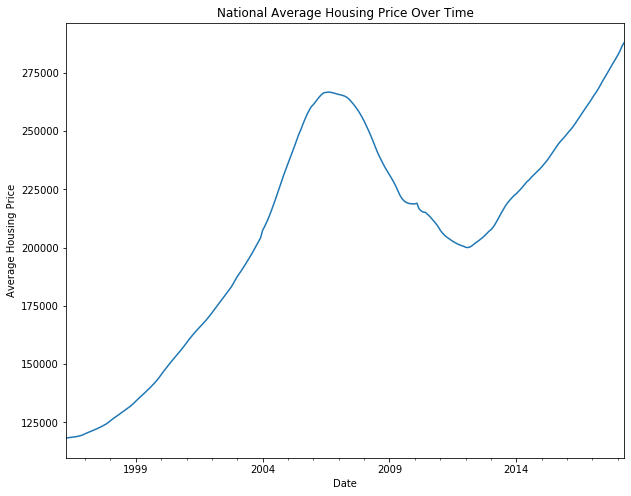

In [8]:
# Finding the national average to plot the overall trend
df_t_withavg = df_t.copy()

# Creating a new column with the monthly average across all of our columns
df_t_withavg["National Average"] = df_t_withavg.iloc[:, 1:-1].mean(axis=1)

# Creating a simple plot of that average
plt.figure(figsize=(10,8))
df_t_withavg["National Average"].plot()

plt.title("National Average Housing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Average Housing Price")

plt.show()

In [9]:
# Creating a df of the last year of the national data, as our test data
df_future = df_t.loc["2017-05":"2018-04"]
df_future

RegionName,60657,75070,77494,60614,79936,77084,10467,60640,77449,94109,...,3765,84781,12429,97028,12720,1338,3293,40404,81225,89155
2017-05-01,991300.0,306200.0,320000.0,1286000.0,118600.0,157700.0,392500.0,785900.0,166700.0,3734000.0,...,118000.0,232000.0,166800.0,332800.0,120100.0,213600.0,195500.0,120700.0,615900.0,328000.0
2017-06-01,999100.0,307000.0,320900.0,1289000.0,118900.0,157700.0,391200.0,795500.0,166700.0,3759300.0,...,119500.0,236600.0,165200.0,332900.0,121200.0,215400.0,197300.0,121100.0,647300.0,331300.0
2017-07-01,1005500.0,308000.0,321000.0,1289800.0,119100.0,157900.0,394400.0,798000.0,166800.0,3767700.0,...,119800.0,241100.0,164200.0,332600.0,122200.0,216800.0,202100.0,121800.0,662800.0,333800.0
2017-08-01,1007500.0,310000.0,320600.0,1287700.0,119400.0,158700.0,400000.0,787100.0,167400.0,3763900.0,...,120000.0,243200.0,166600.0,332900.0,122700.0,217700.0,208400.0,122800.0,671200.0,336400.0
2017-09-01,1007800.0,312500.0,320200.0,1287400.0,120000.0,160200.0,407300.0,776100.0,168400.0,3775000.0,...,120800.0,244300.0,170000.0,335600.0,122300.0,218600.0,212200.0,124600.0,682400.0,339700.0
2017-10-01,1009600.0,314100.0,320400.0,1291500.0,120300.0,161900.0,411600.0,774900.0,169600.0,3799700.0,...,121600.0,248900.0,171000.0,338900.0,122000.0,218500.0,215200.0,126700.0,695600.0,343800.0
2017-11-01,1013300.0,315000.0,320800.0,1296600.0,120300.0,162800.0,413200.0,777900.0,170900.0,3793900.0,...,122600.0,254600.0,170700.0,340500.0,122200.0,218100.0,214300.0,128800.0,695500.0,346800.0
2017-12-01,1018700.0,316600.0,321200.0,1299000.0,120300.0,162800.0,414300.0,777900.0,172300.0,3778700.0,...,123400.0,257600.0,171300.0,341000.0,122800.0,216400.0,213100.0,130600.0,694700.0,348900.0
2018-01-01,1024400.0,318100.0,321200.0,1302700.0,120300.0,162800.0,413900.0,778500.0,173300.0,3770800.0,...,124400.0,258000.0,172400.0,342300.0,123200.0,213100.0,213700.0,131700.0,706400.0,350400.0
2018-02-01,1030700.0,319600.0,323000.0,1306400.0,120500.0,162900.0,411400.0,780500.0,174200.0,3763100.0,...,125500.0,260600.0,173600.0,345000.0,123200.0,209800.0,218300.0,132500.0,705300.0,353000.0


In [10]:
# Creating a training dataframe from the previous 2 years of the national data
df_past = df_t.loc["2015-05":"2017-04"]
df_past

RegionName,60657,75070,77494,60614,79936,77084,10467,60640,77449,94109,...,3765,84781,12429,97028,12720,1338,3293,40404,81225,89155
2015-05-01,915000.0,261200.0,309100.0,1192900.0,115600.0,142100.0,352500.0,677100.0,146000.0,3566500.0,...,110100.0,198500.0,155900.0,318800.0,123300.0,191200.0,186300.0,105900.0,545800.0,293300.0
2015-06-01,916700.0,264700.0,311900.0,1198800.0,115900.0,142900.0,356500.0,682900.0,147100.0,3596400.0,...,110900.0,198000.0,155200.0,318300.0,124000.0,190900.0,188300.0,106800.0,536100.0,295200.0
2015-07-01,917700.0,268400.0,314100.0,1200400.0,115600.0,143900.0,359400.0,688200.0,148400.0,3625500.0,...,112200.0,198000.0,153400.0,320500.0,124800.0,190900.0,190800.0,107500.0,538300.0,296900.0
2015-08-01,919800.0,271400.0,316300.0,1198900.0,115400.0,145200.0,361200.0,692500.0,149700.0,3641400.0,...,113800.0,196800.0,152300.0,323700.0,125700.0,191100.0,191800.0,107700.0,537800.0,298400.0
2015-09-01,925800.0,273600.0,319000.0,1200200.0,115400.0,146200.0,362900.0,698400.0,151200.0,3657900.0,...,114900.0,196700.0,151900.0,326200.0,125500.0,191900.0,189500.0,107800.0,539000.0,299200.0
2015-10-01,937100.0,275200.0,322000.0,1207400.0,115500.0,146900.0,364000.0,708200.0,152300.0,3666000.0,...,116600.0,198900.0,152300.0,328100.0,124900.0,191400.0,187700.0,108300.0,543500.0,299500.0
2015-11-01,948200.0,276400.0,324300.0,1218600.0,115800.0,147600.0,367100.0,717300.0,153100.0,3667000.0,...,118100.0,201400.0,152300.0,330200.0,125300.0,190700.0,186800.0,108600.0,556000.0,301200.0
2015-12-01,951000.0,277000.0,326100.0,1226600.0,116300.0,148500.0,370800.0,726400.0,154200.0,3685600.0,...,118400.0,206000.0,151700.0,331800.0,122900.0,190300.0,186700.0,108700.0,559000.0,303300.0
2016-01-01,952500.0,277900.0,327300.0,1230700.0,116200.0,149600.0,370700.0,734700.0,156100.0,3731000.0,...,117900.0,212500.0,151000.0,333300.0,117100.0,189500.0,186900.0,108900.0,556400.0,304700.0
2016-02-01,958600.0,280000.0,327000.0,1235400.0,115600.0,150600.0,367600.0,739400.0,157800.0,3776100.0,...,117300.0,215300.0,150600.0,334700.0,111400.0,188700.0,186700.0,109800.0,549000.0,305100.0


### Fitting a Simple Linear Regression Model

In [11]:
linreg = LinearRegression()

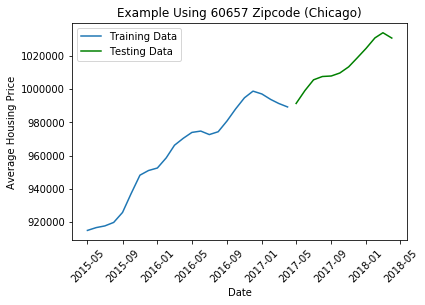

In [12]:
# Plotting the first zipcode in our dataframe, just to get a sense of what a
# column in our data actually looks like visually

ex_x_train = df_past.index
ex_y_train = df_past[60657]
ex_x_test = df_future.index
ex_y_test = df_future[60657]

plt.plot(ex_x_train, ex_y_train, label="Training Data")
plt.plot(ex_x_test, ex_y_test, color="green", label="Testing Data")

plt.title("Example Using 60657 Zipcode (Chicago)")
plt.xlabel("Date")
plt.ylabel("Average Housing Price")
plt.xticks(rotation=45)
plt.legend()

plt.show()

### Playing around with data at the state level, looking only at Texas

In [13]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [14]:
df_tx = df.loc[df["State"] == "TX"]

In [15]:
df_tx.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200


In [16]:
# Using our pre-defined function to create a df with a datetime index
tx_dtindex = zipcodecolumns_datetimeindex(df_tx)

In [17]:
tx_dtindex.head()

RegionName,75070,77494,79936,77084,77449,78660,77573,77584,79912,78572,...,79019,78623,77577,77982,77663,76941,79313,79355,79366,77457
1996-04-01,235700.0,210400.0,77300.0,95000.0,95400.0,138900.0,141400.0,138500.0,119700.0,69900.0,...,NaN,141700.0,60700.0,90700.0,86000.0,NaN,NaN,NaN,134500.0,90700.0
1996-05-01,236900.0,212200.0,77300.0,95200.0,95600.0,138600.0,141000.0,138700.0,119700.0,69700.0,...,NaN,141800.0,61100.0,90900.0,86200.0,NaN,NaN,NaN,134500.0,91000.0
1996-06-01,236700.0,212200.0,77300.0,95400.0,95800.0,138400.0,140600.0,139200.0,119800.0,69600.0,...,NaN,141900.0,61400.0,91000.0,86500.0,NaN,NaN,NaN,134400.0,91200.0
1996-07-01,235400.0,210700.0,77300.0,95700.0,96100.0,138500.0,140500.0,139900.0,119900.0,69300.0,...,NaN,142000.0,61800.0,91100.0,86700.0,NaN,NaN,NaN,134400.0,91500.0
1996-08-01,233300.0,208300.0,77400.0,95900.0,96400.0,138700.0,140400.0,140700.0,120000.0,69100.0,...,NaN,142200.0,62100.0,91300.0,86800.0,NaN,NaN,NaN,134300.0,91800.0


#### Looking at the State-Level Trend

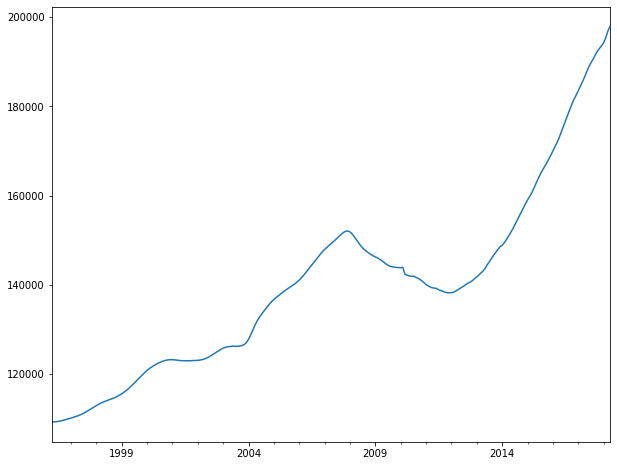

In [18]:
# Creating a new column with the monthly average across all TX zipcodes
tx_dtindex_withavg = tx_dtindex.copy()
tx_dtindex_withavg["Texas Average"] = tx_dtindex_withavg.iloc[:, 1:-1].mean(axis=1)

# Simple plot of the TX average
plt.figure(figsize=(10,8))
tx_dtindex_withavg["Texas Average"].plot()
plt.show()

In [19]:
# Creating a df of the last year of the Texas df, as our test data
tx_future = tx_dtindex.loc["2017-05":"2018-04"]
tx_future

RegionName,75070,77494,79936,77084,77449,78660,77573,77584,79912,78572,...,79019,78623,77577,77982,77663,76941,79313,79355,79366,77457
2017-05-01,306200.0,320000.0,118600.0,157700.0,166700.0,232700.0,247200.0,247100.0,181200.0,97200.0,...,87600.0,258200.0,154700.0,194600.0,150200.0,122100.0,52500.0,99700.0,250300.0,245800.0
2017-06-01,307000.0,320900.0,118900.0,157700.0,166700.0,233900.0,248400.0,248100.0,182400.0,98700.0,...,87400.0,258500.0,156100.0,195900.0,150400.0,122800.0,53700.0,100000.0,252000.0,247700.0
2017-07-01,308000.0,321000.0,119100.0,157900.0,166800.0,235000.0,249800.0,249100.0,183200.0,99800.0,...,88100.0,256100.0,155700.0,197600.0,150500.0,122500.0,55400.0,100500.0,252100.0,250400.0
2017-08-01,310000.0,320600.0,119400.0,158700.0,167400.0,235900.0,251300.0,249900.0,183700.0,100300.0,...,88300.0,254100.0,151300.0,200200.0,150400.0,121800.0,56300.0,100500.0,251600.0,253300.0
2017-09-01,312500.0,320200.0,120000.0,160200.0,168400.0,236600.0,252300.0,250500.0,184500.0,100300.0,...,87600.0,253900.0,147400.0,203700.0,150100.0,121600.0,55700.0,101000.0,251600.0,256900.0
2017-10-01,314100.0,320400.0,120300.0,161900.0,169600.0,237400.0,252400.0,250700.0,185300.0,100100.0,...,87600.0,255500.0,146500.0,204900.0,149900.0,122200.0,56300.0,100700.0,251500.0,256100.0
2017-11-01,315000.0,320800.0,120300.0,162800.0,170900.0,238500.0,252300.0,251000.0,185300.0,100000.0,...,87400.0,257700.0,145900.0,202100.0,149900.0,123500.0,58900.0,99700.0,251300.0,250700.0
2017-12-01,316600.0,321200.0,120300.0,162800.0,172300.0,239400.0,253100.0,251400.0,184700.0,100100.0,...,86300.0,260900.0,145600.0,200000.0,150100.0,124700.0,61500.0,97700.0,251500.0,243200.0
2018-01-01,318100.0,321200.0,120300.0,162800.0,173300.0,240000.0,254700.0,251900.0,184800.0,99700.0,...,85200.0,262700.0,145000.0,200800.0,149800.0,124300.0,63000.0,95800.0,251700.0,238300.0
2018-02-01,319600.0,323000.0,120500.0,162900.0,174200.0,241000.0,257100.0,253200.0,185900.0,100200.0,...,84500.0,267100.0,145100.0,201300.0,149500.0,122600.0,63600.0,94600.0,252500.0,234200.0


In [20]:
# Creating a past dataframe from the rest of the Texas data
tx_past = tx_dtindex.loc["1996-04":"2017-04"]
tx_past.tail(10)

RegionName,75070,77494,79936,77084,77449,78660,77573,77584,79912,78572,...,79019,78623,77577,77982,77663,76941,79313,79355,79366,77457
2016-07-01,292000.0,329000.0,114000.0,155200.0,167400.0,216000.0,240600.0,241700.0,172400.0,91000.0,...,84400.0,254700.0,130100.0,184500.0,147300.0,112300.0,56600.0,92800.0,232000.0,224900.0
2016-08-01,292800.0,327800.0,113900.0,155500.0,168200.0,217400.0,241400.0,241400.0,172500.0,91600.0,...,83900.0,255900.0,134000.0,185500.0,147500.0,112500.0,57000.0,94300.0,235000.0,225200.0
2016-09-01,293700.0,326700.0,114100.0,155400.0,168500.0,219000.0,242500.0,242000.0,173000.0,92200.0,...,84300.0,257100.0,139000.0,185900.0,147500.0,113400.0,56700.0,96300.0,236100.0,225400.0
2016-10-01,295200.0,325500.0,114900.0,155000.0,168500.0,221200.0,243600.0,243200.0,174000.0,93000.0,...,85000.0,258200.0,142200.0,186600.0,147600.0,114500.0,55100.0,97900.0,236600.0,225800.0
2016-11-01,297000.0,324700.0,115700.0,155100.0,168600.0,223100.0,244400.0,244200.0,175200.0,93500.0,...,85200.0,257700.0,144000.0,187800.0,147800.0,114600.0,52700.0,97900.0,238100.0,227900.0
2016-12-01,299000.0,324500.0,116300.0,155900.0,168500.0,224300.0,245000.0,244700.0,176300.0,94100.0,...,85700.0,256800.0,146800.0,188900.0,147800.0,114100.0,50600.0,97900.0,240700.0,231300.0
2017-01-01,300800.0,323700.0,116900.0,156500.0,168300.0,225600.0,245400.0,245300.0,177700.0,95100.0,...,86900.0,257500.0,149900.0,189900.0,148400.0,115100.0,49800.0,97800.0,243200.0,234400.0
2017-02-01,301800.0,322300.0,117300.0,156900.0,167900.0,227300.0,245800.0,246100.0,178900.0,95900.0,...,87600.0,258300.0,152000.0,190800.0,149400.0,117800.0,50700.0,98300.0,244300.0,237100.0
2017-03-01,302800.0,320700.0,117600.0,157300.0,167300.0,229200.0,246000.0,246500.0,179700.0,96000.0,...,87600.0,257400.0,153600.0,191800.0,150200.0,120300.0,51800.0,98700.0,245100.0,241300.0
2017-04-01,304400.0,320000.0,118000.0,157600.0,166800.0,231000.0,246200.0,246700.0,180300.0,96100.0,...,87900.0,257100.0,154800.0,193100.0,150300.0,121500.0,52300.0,99200.0,247300.0,244200.0


In [21]:
# Checking for a sum total of all null values
tx_past.isnull().sum().sum()

6989

In [22]:
# Finding zipcodes with null values
null_zips = []

for column in tx_past.columns:
    if tx_past[column].isnull().values.any() == True:
        null_zips.append(column)
    
print(null_zips)

[75078, 76234, 79045, 79029, 79415, 75862, 79735, 76426, 76078, 76704, 78834, 75210, 75941, 78616, 76023, 79339, 79323, 79347, 79836, 76458, 76073, 76380, 79356, 78373, 78560, 76457, 76071, 76431, 78593, 79521, 79235, 75432, 76225, 79329, 78832, 79373, 76530, 76430, 79041, 79064, 79086, 79019, 76941, 79313, 79355]


In [23]:
len(null_zips)

45

In [24]:
len(tx_past.columns)

989

In [25]:
# Dropping columns with nulls, since there are only 45 / 989 (less than 5%)
# Chose to do this rather than backfilling with the first value we have, just
# for this initial value of our data across all available dates
# Would not want to do this for examinations of more recent data, since some
# analysis revealed these nulls are mostly early dates 

tx_past_nonulls = tx_past.drop(null_zips, axis="columns")

# Sanity check
tx_past_nonulls.isnull().sum().sum()

0

In [26]:
def stationarity_check(TS, threshold):
    '''
    Creating a function to conduct an adjusted Dickey-Fuller test for 
    stationarity, which returns only those columns in the provided pandas 
    dataframe, 'TS', which have a p-value lower than our provided threshold
    
    Note! Must remove null values from the dataframe, TS, before running
    this function
    
    Expected inputs:
    TS : pandas dataframe, where the index is a datetimeindex and each
         column is the timeseries data to be examined (with nulls removed)
    threshold: float of the p-value threshold to be tested against
    
    Expected output:
    results: list of column names which passed the adjusted Dickey-Fuller test
    '''
    # Create an empty list to hold results of the Adjusted Dickey-Fuller test
    results = []
    
    # Perform the Dickey-Fuller test on each column
    for column in TS.columns:
        dftest = adfuller(TS[column])  
        # Examines whether the p-value result (dftest[1]) is less than or 
        # equal to the threshold provided
        if dftest[1] <= threshold:
            # If the p-value result is less than or equal to the threshold, 
            # appends the column name to the results list
            results.append(column)
    
    return results 

In [27]:
# Running a stationarity check to test the function, against a 1% threshold
stationarity_check(tx_past_nonulls, .01)

# We can say the below zipcodes are stationary with 99% confidence, before any
# further action to make that data stationary

[77494, 78735]

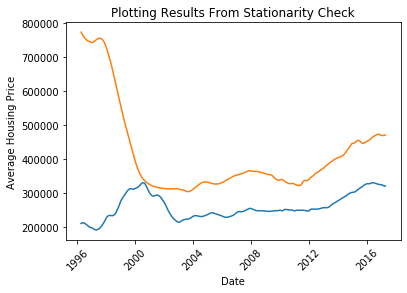

In [28]:
# Checking out what these two resulting zipcodes look like

plt.plot(tx_past_nonulls.index, tx_past_nonulls[77494])
plt.plot(tx_past_nonulls.index, tx_past_nonulls[78735])

plt.title("Plotting Results From Stationarity Check")
plt.xlabel("Date")
plt.ylabel("Average Housing Price")
plt.xticks(rotation=45)

plt.show()

Alas, perhaps that function doesn't work after all.

### Visualizing our State-Level Data

In [29]:
# More imports for better maps
import folium
from folium import plugins

# This library allows us to search for a zipcode and retrieve lat/long data
from uszipcode import SearchEngine

In [30]:
# Instantiating the zipcode search engine
search = SearchEngine(simple_zipcode=True)

In [31]:
# Going back to our Texas dataframe, since we no longer need a datetime index
df_tx.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
8,91940,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200


In [32]:
# Changing the index to be the zipcode
tx_zip = df_tx.set_index(df_tx["RegionName"])

# Dropping the metadata columns
tx_zip = tx_zip.drop(columns=["RegionID", "RegionName",
                              "City", "State", "Metro",
                              "CountyName", "SizeRank"])

In [33]:
tx_zip.head()

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
RegionName,,,,,,,,,,,,,,,,,,,,,
75070,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,215800.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
77494,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
79936,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,77700.0,77700.0,77800.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
77084,95000.0,95200.0,95400.0,95700.0,95900.0,96100.0,96200.0,96100.0,96000.0,95800.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
77449,95400.0,95600.0,95800.0,96100.0,96400.0,96700.0,96800.0,96800.0,96700.0,96600.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200


In [34]:
# Only looking at data from 2014 to most recent data (4/2018), for simplicity
# and to avoid the rows we found earlier that had NaNs for earlier years

tx_zip = tx_zip.loc[:,"2014-01":]
print(tx_zip.shape)
tx_zip.head()

(989, 52)


,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
RegionName,,,,,,,,,,,,,,,,,,,,,
75070,231800.0,233000.0,234200.0,235400.0,236600.0,238500.0,240500,242600,244700,246300,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
77494,277600.0,279800.0,282100.0,284200.0,286000.0,288300.0,290700,293300,295900,298300,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
79936,111500.0,111400.0,112000.0,112500.0,112700.0,113100.0,113900,114400,114500,114400,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
77084,124200.0,124900.0,125900.0,127100.0,128200.0,129400.0,130300,130900,131900,133300,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
77449,128300.0,129100.0,130000.0,131200.0,132500.0,133600.0,134500,135400,136500,137700,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200


In [35]:
# Importing the preprocessing library to normalize the house price data
from sklearn import preprocessing

# Creating an array of the normalized data
tx_norm = preprocessing.normalize(tx_zip)
# Setting that array as a dataframe, with the same row/column labels as before
tx_scaled = pd.DataFrame(tx_norm, index=tx_zip.index, columns=tx_zip.columns)
tx_scaled.head()

,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
RegionName,,,,,,,,,,,,,,,,,,,,,
75070,0.114535,0.115128,0.115720,0.116313,0.116906,0.117845,0.118833,0.119871,0.120909,0.121699,...,0.152186,0.153174,0.154409,0.155200,0.155645,0.156435,0.157176,0.157917,0.158659,0.159004
77494,0.122553,0.123525,0.124540,0.125467,0.126262,0.127277,0.128337,0.129484,0.130632,0.131692,...,0.141713,0.141537,0.141360,0.141448,0.141625,0.141802,0.141802,0.142596,0.144318,0.145642
79936,0.133243,0.133123,0.133840,0.134438,0.134677,0.135155,0.136111,0.136708,0.136828,0.136708,...,0.142325,0.142683,0.143400,0.143759,0.143759,0.143759,0.143759,0.143998,0.144595,0.145193
77084,0.116205,0.116860,0.117796,0.118919,0.119948,0.121071,0.121913,0.122474,0.123410,0.124720,...,0.147736,0.148485,0.149888,0.151479,0.152321,0.152321,0.152321,0.152414,0.152976,0.153724
77449,0.114081,0.114792,0.115592,0.116659,0.117815,0.118793,0.119594,0.120394,0.121372,0.122439,...,0.148314,0.148847,0.149736,0.150803,0.151959,0.153204,0.154093,0.154894,0.155961,0.156672


In [36]:
# for zipcode in tx_zip.index:
#     zipc = search.by_zipcode(zipcode)
#     tx_zip["Lat"][zipcode] = zipc.lat
#     tx_zip["Long"][zipcode] = zipc.lng

# tx_zip.head()

In [37]:
# Creating an empty dictionary to hold found zipcode values
zipcode_dict = {}

# Using our zipcode search engine to find lat/long data per zipcode
for zipcode in tx_scaled.index:
    zipc = search.by_zipcode(zipcode)
    zipcode_dict[zipcode] = [zipc.lat, zipc.lng]

len(zipcode_dict)

989

In [38]:
# Creating lists to hold those lat/long values
lats = []
longs = []

# Appending lat/long values to those lists
for zipcode in zipcode_dict.keys():
    lats.append(zipcode_dict[zipcode][0])
    longs.append(zipcode_dict[zipcode][1])

print(len(lats), len(longs))

989 989


In [39]:
# Adding those lists to our dataframe
tx_scaled["Lat"] = lats
tx_scaled["Long"] = longs

tx_scaled.head()

,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Lat,Long
RegionName,,,,,,,,,,,,,,,,,,,,,
75070,0.114535,0.115128,0.115720,0.116313,0.116906,0.117845,0.118833,0.119871,0.120909,0.121699,...,0.154409,0.155200,0.155645,0.156435,0.157176,0.157917,0.158659,0.159004,33.16,-96.72
77494,0.122553,0.123525,0.124540,0.125467,0.126262,0.127277,0.128337,0.129484,0.130632,0.131692,...,0.141360,0.141448,0.141625,0.141802,0.141802,0.142596,0.144318,0.145642,29.74,-95.84
79936,0.133243,0.133123,0.133840,0.134438,0.134677,0.135155,0.136111,0.136708,0.136828,0.136708,...,0.143400,0.143759,0.143759,0.143759,0.143759,0.143998,0.144595,0.145193,31.78,-106.31
77084,0.116205,0.116860,0.117796,0.118919,0.119948,0.121071,0.121913,0.122474,0.123410,0.124720,...,0.149888,0.151479,0.152321,0.152321,0.152321,0.152414,0.152976,0.153724,29.83,-95.66
77449,0.114081,0.114792,0.115592,0.116659,0.117815,0.118793,0.119594,0.120394,0.121372,0.122439,...,0.149736,0.150803,0.151959,0.153204,0.154093,0.154894,0.155961,0.156672,29.83,-95.73


In [40]:
# Alas! Found some nulls in our lat/long data
tx_scaled.loc[tx_scaled["Long"].isna() == True]

,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Lat,Long
RegionName,,,,,,,,,,,,,,,,,,,,,
75033,0.115829,0.116062,0.116371,0.116604,0.117146,0.117804,0.118384,0.118926,0.119546,0.120010,...,0.151716,0.152375,0.153110,0.153342,0.153381,0.153846,0.154504,0.154659,NaN,NaN
78599,0.130439,0.131580,0.132150,0.131960,0.130819,0.130249,0.130439,0.131200,0.131770,0.131960,...,0.146031,0.146411,0.146411,0.146601,0.147552,0.149073,0.151355,0.153257,NaN,NaN
76005,0.121238,0.120500,0.119955,0.119800,0.120189,0.121160,0.122210,0.122482,0.122443,0.122288,...,0.148992,0.147476,0.145804,0.145455,0.145455,0.145260,0.145338,0.145338,NaN,NaN


In [41]:
# Filling null values with lat/long data found on www.zip-codes.com
# Was able to do this since there were only 3 zipcodes with nulls

# Adding lat/long for 75033, Frisco TX
tx_scaled.at[75033, "Lat"] = 33.18
tx_scaled.at[75033, "Long"] = -96.84

# Adding lat/long for 78599, Weslaco TX
tx_scaled.at[78599, "Lat"] = 26.15
tx_scaled.at[78599, "Long"] = -97.99

# Adding lat/long for 76005, Arlington TX
tx_scaled.at[76005, "Lat"] = 32.73
tx_scaled.at[76005, "Long"] = -97.10

In [42]:
# Sanity check, to make sure we have no nulls at all
tx_scaled.isnull().sum().sum()

0

In [43]:
tx_scaled.iloc[4]["Long"]

-95.73

In [44]:
# for col in range(tx_zip.shape[1]):
#     for row in range(tx_zip.shape[0]):
#         list(list([tx_zip.iloc[row]["Lat"],
#              tx_zip.iloc[row]["Long"],
#              tx_zip.iloc[row,col]]))

In [45]:
tx_scaled.head()

,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Lat,Long
RegionName,,,,,,,,,,,,,,,,,,,,,
75070,0.114535,0.115128,0.115720,0.116313,0.116906,0.117845,0.118833,0.119871,0.120909,0.121699,...,0.154409,0.155200,0.155645,0.156435,0.157176,0.157917,0.158659,0.159004,33.16,-96.72
77494,0.122553,0.123525,0.124540,0.125467,0.126262,0.127277,0.128337,0.129484,0.130632,0.131692,...,0.141360,0.141448,0.141625,0.141802,0.141802,0.142596,0.144318,0.145642,29.74,-95.84
79936,0.133243,0.133123,0.133840,0.134438,0.134677,0.135155,0.136111,0.136708,0.136828,0.136708,...,0.143400,0.143759,0.143759,0.143759,0.143759,0.143998,0.144595,0.145193,31.78,-106.31
77084,0.116205,0.116860,0.117796,0.118919,0.119948,0.121071,0.121913,0.122474,0.123410,0.124720,...,0.149888,0.151479,0.152321,0.152321,0.152321,0.152414,0.152976,0.153724,29.83,-95.66
77449,0.114081,0.114792,0.115592,0.116659,0.117815,0.118793,0.119594,0.120394,0.121372,0.122439,...,0.149736,0.150803,0.151959,0.153204,0.154093,0.154894,0.155961,0.156672,29.83,-95.73


In [46]:
tx_scaled.shape

(989, 54)

In [47]:
column_list = list(tx_scaled.columns)
column_list.remove("Lat")
column_list.remove("Long")
len(column_list)

52

In [48]:
row_list = list(tx_scaled.index)
len(row_list)

989

In [49]:
heat_data = []

for col in column_list:
    lat_long_weight = []
    for row in row_list:
        row_data = [tx_scaled.loc[row]["Lat"],
                    tx_scaled.loc[row]["Long"],
                    round(tx_scaled.loc[row, col], 4)]
        lat_long_weight.append(row_data)
    heat_data.append(lat_long_weight)

In [50]:
heat_array = np.array(heat_data)

In [51]:
heat_array[0]

array([[  33.16  ,  -96.72  ,    0.1145],
       [  29.74  ,  -95.84  ,    0.1226],
       [  31.78  , -106.31  ,    0.1332],
       ...,
       [  33.2   , -102.8   ,    0.1174],
       [  33.53  , -101.69  ,    0.1171],
       [  28.65  ,  -95.97  ,    0.1198]])

In [52]:
texas_map = folium.Map(location=[31.2686, -99.9018],
                       zoom_start=6, prefer_canvas=True)


hmwt = plugins.HeatMapWithTime(heat_data)
hmwt.add_to(texas_map)

texas_map

In [53]:
from state_heatmapwithtime import *

In [54]:
# df_ga = df.loc[df["State"] == "GA"]
# df_ga.head()

In [55]:
ga_data = getdata_stateheatmapwithtime(df, "GA")

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
ga_map = folium.Map(location=[32.1656, -82.9001],
                       zoom_start=6, prefer_canvas=True)

plugins.HeatMapWithTime(ga_data).add_to(ga_map)

ga_map